In [1]:
# Restart kernel if you see torch errors
import pandas as pd
import numpy as np
import torch
print(f"Torch version: {torch.__version__}")

from transformers import pipeline
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt


Torch version: 2.9.1


/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load migration speeches dataset
df = pd.read_csv("migration_speeches_lda.csv", sep="\t")
print(f"Loaded {len(df)} speeches")
print(f"Columns: {df.columns.tolist()}")

Loaded 7870 speeches
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'speaker', 'text', 'party', 'date', 'agenda', 'speechnumber', 'procedure_ID', 'partyfacts_ID', 'period', 'chair', 'MEP', 'commission', 'written', 'multispeaker', 'link', 'translatedText', 'translationSource', 'year', 'uq_agenda', 'party_adj', 'party_block', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34', 'topic_35', 'topic_36', 'topic_37', 'topic_38', 'topic_39', 'topic_40', 'topic_41', 'topic_42', 'topic_43', 'topic_44', 'topic_45', 'topic_46', 'topic_47', 'topic_48', 'topic_49']


In [3]:
# Load the multilingual sentiment analysis model
print("Loading sentiment analysis model...")
pipe = pipeline("text-classification", model="tabularisai/multilingual-sentiment-analysis")
print("Model loaded successfully!")

Loading sentiment analysis model...


Device set to use mps:0


Model loaded successfully!


In [4]:
# Test the model on a sample sentence
test_sentence = "I love this product! It's amazing and works perfectly."
test_result = pipe(test_sentence)
print(f"Test sentence: {test_sentence}")
print(f"Result: {test_result}")

Test sentence: I love this product! It's amazing and works perfectly.
Result: [{'label': 'Very Positive', 'score': 0.5586304664611816}]


## Apply sentiment analysis to all speeches

In [5]:
# Function to analyze sentiment with error handling
def analyze_sentiment(text):
    """Analyze sentiment of text, handling errors and edge cases"""
    try:
        if pd.isna(text) or len(str(text).strip()) == 0:
            return None, None
        
        # Truncate very long texts (model has max token limit)
        text_str = str(text)[:512]
        
        
        result = pipe(text_str)[0]
        return result['label'], result['score']
    except Exception as e:
        print(f"Error processing text: {e}")
        return None, None

In [6]:
# Apply sentiment analysis to all speeches
print(f"Analyzing sentiment for {len(df)} speeches...")
print("This may take a while...")

# Create lists to store results
sentiments = []
sentiment_scores = []

# Process each speech
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing sentiment"):
    sentiment, score = analyze_sentiment(row['translatedText'])
    sentiments.append(sentiment)
    sentiment_scores.append(score)

# Add results to dataframe
df['sentiment'] = sentiments
df['sentiment_score'] = sentiment_scores

print(f"\nCompleted! Successfully analyzed {df['sentiment'].notna().sum()} speeches")
print(f"Failed to analyze {df['sentiment'].isna().sum()} speeches")

Analyzing sentiment for 7870 speeches...
This may take a while...


Analyzing sentiment: 100%|██████████| 7870/7870 [01:49<00:00, 71.57it/s]


Completed! Successfully analyzed 7870 speeches
Failed to analyze 0 speeches


## Analyze sentiment results

In [7]:
# Distribution of sentiment labels
print("Sentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nPercentages:")
print(df['sentiment'].value_counts(normalize=True) * 100)

Sentiment distribution:
sentiment
Neutral          4905
Negative         1804
Very Negative     569
Positive          432
Very Positive     160
Name: count, dtype: int64

Percentages:
sentiment
Neutral          62.325286
Negative         22.922490
Very Negative     7.229987
Positive          5.489199
Very Positive     2.033037
Name: proportion, dtype: float64


In [8]:
# Average sentiment score by label
print("Average confidence scores by sentiment:")
print(df.groupby('sentiment')['sentiment_score'].agg(['mean', 'std', 'count']))

Average confidence scores by sentiment:
                   mean       std  count
sentiment                               
Negative       0.619301  0.151145   1804
Neutral        0.783501  0.161868   4905
Positive       0.586063  0.164320    432
Very Negative  0.606044  0.158292    569
Very Positive  0.483754  0.138843    160


In [9]:
# Sentiment by party
print("Sentiment distribution by party:")
sentiment_by_party = pd.crosstab(df['party_adj'], df['sentiment'], normalize='index') * 100
print(sentiment_by_party.round(2))

Sentiment distribution by party:
sentiment        Negative  Neutral  Positive  Very Negative  Very Positive
party_adj                                                                 
ECR                 28.78    54.51      4.91           8.75           3.05
EFD                 23.10    60.28      3.66          11.27           1.69
ELDR/ALDE/Renew     23.81    57.31      9.36           7.06           2.46
ENF/ID              25.27    60.43      3.21           7.09           4.01
Greens/EFA          28.13    43.74      7.57          16.08           4.49
INDDEM/EDD          19.15    72.34      4.26           4.26           0.00
NGL/The Left        21.23    63.44      3.07          10.80           1.47
PPE                 19.89    69.00      6.50           3.09           1.52
PSE/S&D             22.70    63.64      5.11           7.48           1.08
UEN                 14.29    71.43      7.14           3.57           3.57


In [27]:
# plotting parameters
party_block_colors = {
    'left': 'purple',
    'greens': 'green',
    'social_democratic': 'red',
    'christian_conservative': 'black',
    'liberal': 'orange',
    'right_populist': 'blue'
}
election_years = [1999, 2004, 2009, 2014, 2019, 2024]

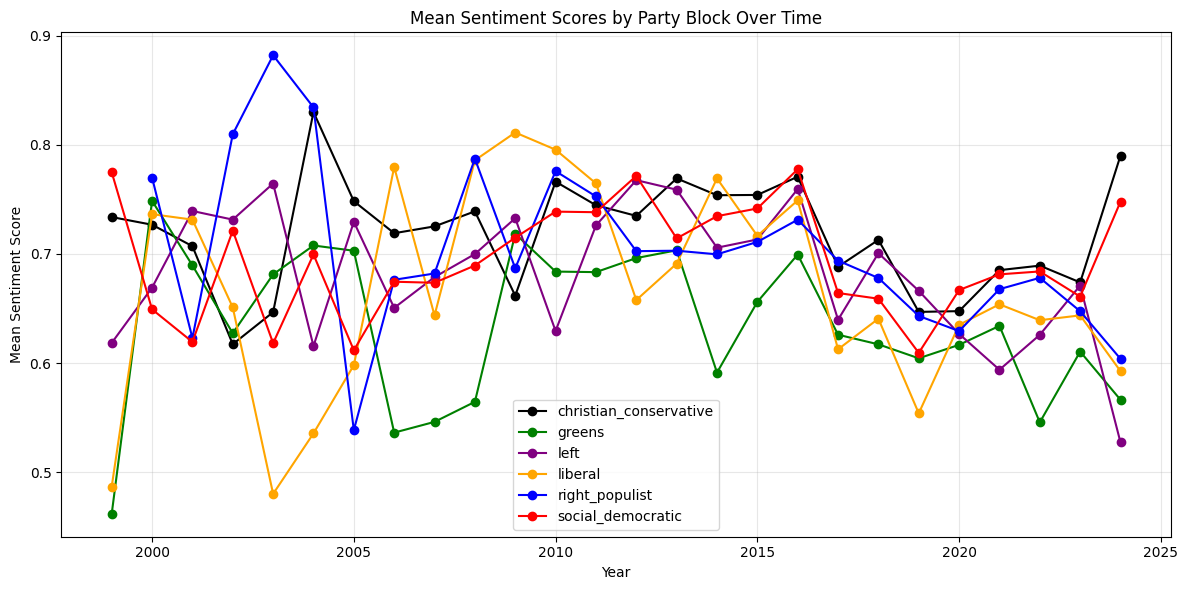

In [36]:
# plot mean sentiment scores by party and year
sentiment_party_year = df.groupby(["party_block", "year"]).agg({"sentiment_score": "mean"})

plt.figure(figsize=(12, 6))
for party in sentiment_party_year.index.get_level_values('party_block').unique():
    party_data = sentiment_party_year.loc[party]
    plt.plot(party_data.index, party_data['sentiment_score'], marker='o', label=party, color=party_block_colors.get(party))

plt.xlabel('Year')
plt.ylabel('Mean Sentiment Score')
plt.title('Mean Sentiment Scores by Party Block Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


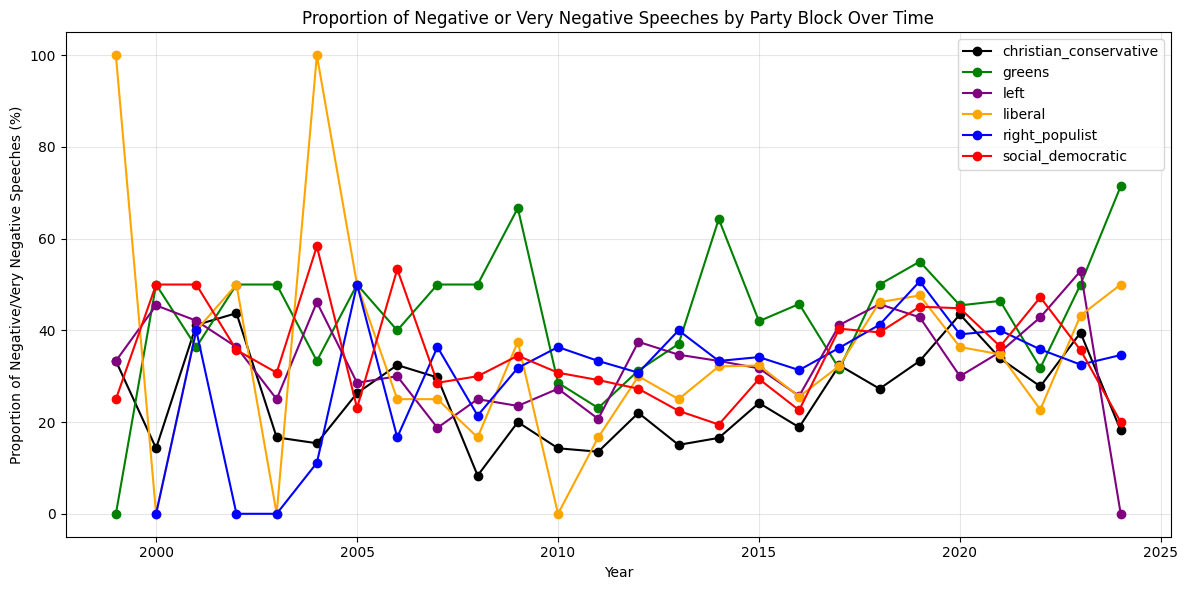

In [33]:
# Create a binary variable for negative sentiment (Negative or Very Negative)
df['is_negative'] = df['sentiment'].isin(['Negative', 'Very Negative'])

# Calculate proportion of negative speeches by party and year
negative_by_party_year = df.groupby(['party_block', 'year'])['is_negative'].mean() * 100

# Plot the results
plt.figure(figsize=(12, 6))
for party in negative_by_party_year.index.get_level_values('party_block').unique():
    party_data = negative_by_party_year.loc[party]
    plt.plot(party_data.index, party_data.values, marker='o', label=party, color = party_block_colors.get(party))

plt.xlabel('Year')
plt.ylabel('Proportion of Negative/Very Negative Speeches (%)')
plt.title('Proportion of Negative or Very Negative Speeches by Party Block Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


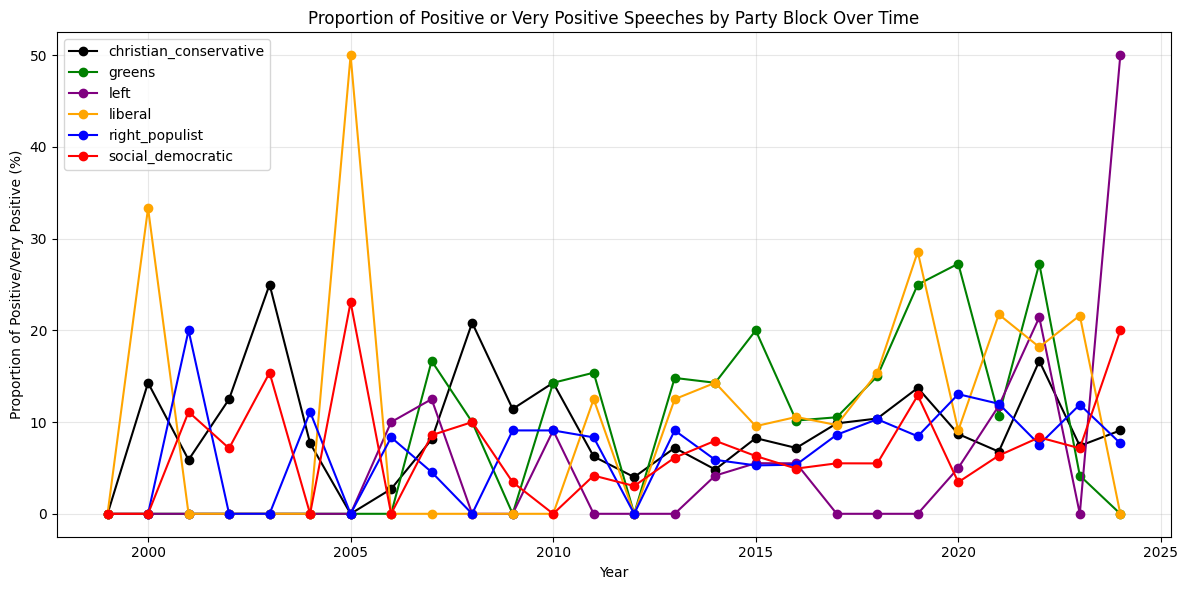

In [30]:
# Create a binary variable for negative sentiment (Negative or Very Negative)
df['is_positive'] = df['sentiment'].isin(['Positive', 'Very Positive'])

# Calculate proportion of negative speeches by party and year
negative_by_party_year = df.groupby(['party_block', 'year'])['is_positive'].mean() * 100

# Plot the results
plt.figure(figsize=(12, 6))
for party in negative_by_party_year.index.get_level_values('party_block').unique():
    party_data = negative_by_party_year.loc[party]
    plt.plot(party_data.index, party_data.values, marker='o', label=party, color=party_block_colors.get(party))

plt.xlabel('Year')
plt.ylabel('Proportion of Positive/Very Positive (%)')
plt.title('Proportion of Positive or Very Positive Speeches by Party Block Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

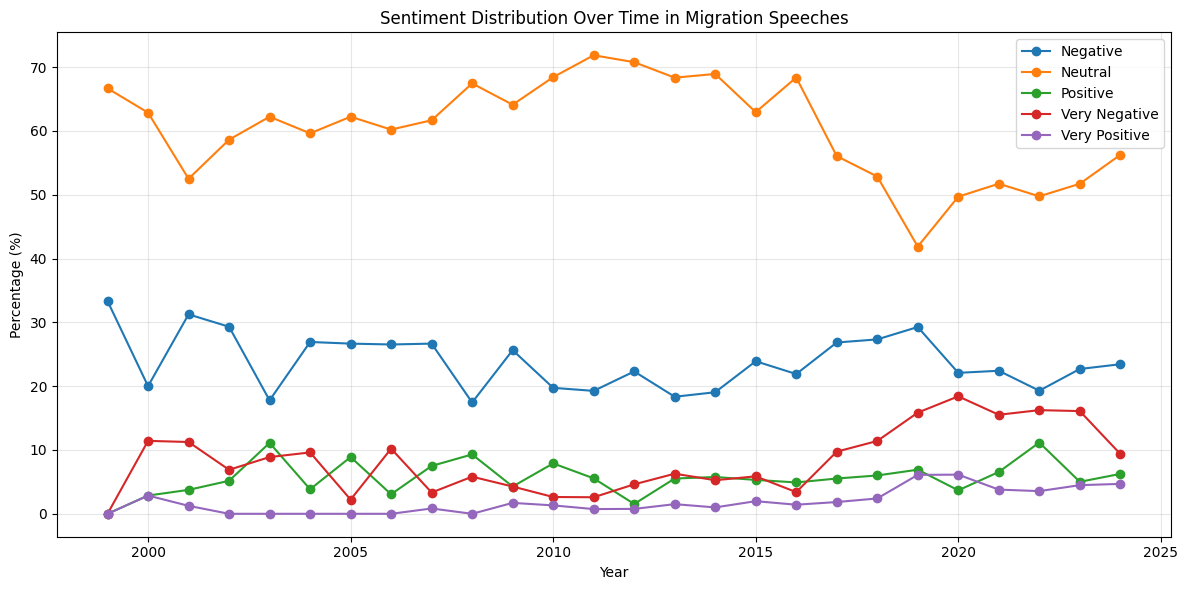

In [10]:
# Sentiment over time

sentiment_by_year = pd.crosstab(df['year'], df['sentiment'], normalize='index') * 100

plt.figure(figsize=(12, 6))
for sentiment in sentiment_by_year.columns:
    plt.plot(sentiment_by_year.index, sentiment_by_year[sentiment], marker='o', label=sentiment)
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.title('Sentiment Distribution Over Time in Migration Speeches')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Sample speeches by sentiment
print("Sample VERY POSITIVE speeches:")
positive_samples = df[df['sentiment'] == 'Very Positive'].nlargest(3, 'sentiment_score')

for idx, row in positive_samples.iterrows():
    print(f"\n{'='*100}")
    print(f"Year: {row['year']}, Party: {row['party_adj']}, Score: {row['sentiment_score']:.3f}")
    print(f"Speaker: {row['speaker']}")
    print(f"\nTranslated Text:")
    print(f"{row['translatedText']}")
    print('='*100)


Sample POSITIVE speeches:

Year: 2019, Party: PSE/S&D, Score: 0.818
Speaker: Pietro Bartolo

Translated Text:
Mr President, honourable colleagues, it is with emotion and respect that I address this Chamber for the first time. I am from Lampedusa – perhaps some of you do not know this – and for thirty years in Lampedusa, the gateway to Europe, I have personally rescued, personally welcomed, and personally cared for those who arrive after a long journey at sea. I have seen pure horror, I have conducted thousands of body inspections, I have seen hormonal tortures, I have seen the rubber boat disease – some here do not know what I am talking about – I have seen so many horrors, which I do not wish to describe here. Europe cannot abandon men, women, and children at sea and send them back into the hell of Libya. We have a responsibility towards these people. For this reason, I urgently call for a new European search and rescue plan in the Mediterranean. In recent years, NGOs active in the Me

In [23]:
print("\nSample VERY NEGATIVE speeches:")
negative_samples = df[df['sentiment'] == 'Very Negative'].nlargest(3, 'sentiment_score')

for idx, row in negative_samples.iterrows():
    print(f"\n{'='*100}")
    print(f"Year: {row['year']}, Party: {row['party_adj']}, Score: {row['sentiment_score']:.3f}")
    print(f"Speaker: {row['speaker']}")
    print(f"\nTranslated Text:")
    print(f"{row['translatedText'][:300]}...")
    print('='*100)


Sample VERY NEGATIVE speeches:

Year: 2020, Party: NGL/The Left, Score: 0.931
Speaker: Nikolaj Villumsen

Translated Text:
Madam President! The situation for refugees on the Greek islands is completely catastrophic. Overcrowded camps, open sewers, flooded tents. This is the situation for tens of thousands of refugees. Worst of all is contemplating the thousands of unaccompanied children who are sitting there in the mud....

Year: 2023, Party: PPE, Score: 0.916
Speaker: Alessandra Mussolini

Translated Text:
Mr. President, honourable colleagues, what a disgrace! What a disgrace to hear even Italian representatives exploiting the dead just to go against a government. The tragedy of Cutro is not an Italian tragedy, it is a European tragedy. And the solutions must be European. But why don't we also talk ab...

Year: 2016, Party: ENF/ID, Score: 0.912
Speaker: Marine Le Pen

Translated Text:
Mr President, ladies and gentlemen, the truth is cruel! During the latest negotiations between Turke

## Save results

In [ ]:
# Save the dataframe with sentiment analysis results
output_file = "migration_speeches_with_sentiment.csv"
df.to_csv(output_file, sep="\t", index=False)
print(f"Saved results to {output_file}")
print(f"Total speeches: {len(df)}")
print(f"Columns: {df.columns.tolist()}")